# **Pairing Averaged**

In [80]:
import numpy as np
import matplotlib.pyplot as plt

import Materials_Parameters as mp
from MTI_Second_Order import FMTI2_NeumannBC, Change_Basis, Block_Decomposition, Block_Reverse

# parameters
d = 100.; mu = 0.010; Delta = 0.005; L = 0.010
# coupling matrices        f = 0.
Gamma = np.matrix([[1,0],[0,1],[1,0],[0,1]])



zero = np.zeros((2,2))

def Get_Spin_Projections(f):
    
    # block decomposition
    fuu, fud, fdu, fdd = Block_Decomposition(f)

    # S = 0 components
    f_0 = 0.5 * np.block([[zero, fud+fdu],[fdu+fud, zero]])

    # S = 1 components
    f_p1 = np.block([[fuu, zero],[zero, zero]])

    # S = -1 components
    f_m1 = np.block([[zero, zero],[zero, fdd]])

    return f_0, f_p1, f_m1 

## Zero Magnetization $\Lambda = 0$ meV

In [81]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("pairing_L-0.txt")

# store data in matrices
F_data = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_data[idx][jdx] = Change_Basis(matrix)

print(F_data.shape)

(100, 100, 4, 4)


#### <font color='green'> **Contour Plot** </font> 

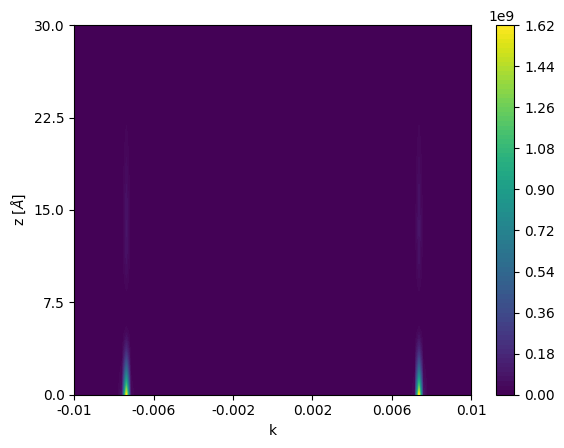

In [48]:
F = np.empty((k_dim, z_dim))

for idx in range(k_dim):
    for jdx in range(z_dim):

        F[idx][jdx] = np.linalg.norm(F_data[idx][jdx])


contour = plt.contourf(F.T, levels=100)
plt.colorbar(contour)

y_ticks = np.linspace(0, len(Z)-1, 5)
y_labels = np.linspace(Z[0], Z[-1], 5)

x_ticks = np.linspace(0, len(K)-1, 6)
x_labels = np.linspace(K[0], K[-1], 6)


plt.xticks(x_ticks, x_labels);
plt.yticks(y_ticks, y_labels);

plt.xlabel('k')
plt.ylabel('z [$\AA$]');

### **Spin Symmetry**

In [74]:
k_dim, z_dim, n1,n2 = F_data.shape

F_swap = np.array([[Block_Reverse(f) for f in F1] for F1 in F_data])

# matrices for signlet
F_singlet = 0.5*(F_data - F_swap)
# matrices for triplet
F_triplet = 0.5*(F_data + F_swap)

fs = np.array([[np.linalg.norm(f) for f in F1] for F1 in F_singlet])
ft = np.array([[np.linalg.norm(f) for f in F1] for F1 in F_triplet])
norm = np.max(fs+ft)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


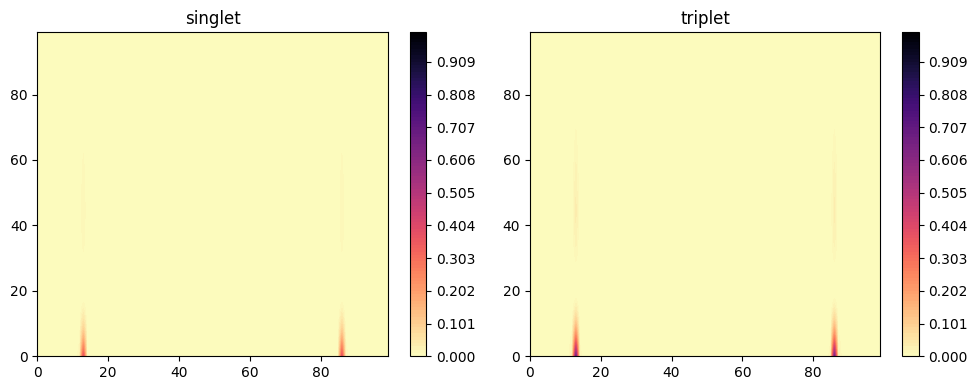

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(fs.T/norm, levels=np.linspace(0,1, 100),  cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('singlet')

# Second contour plot
c2 = axes[1].contourf(ft.T/norm, levels=np.linspace(0,1, 100), cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('triplet')


plt.tight_layout()
plt.show()

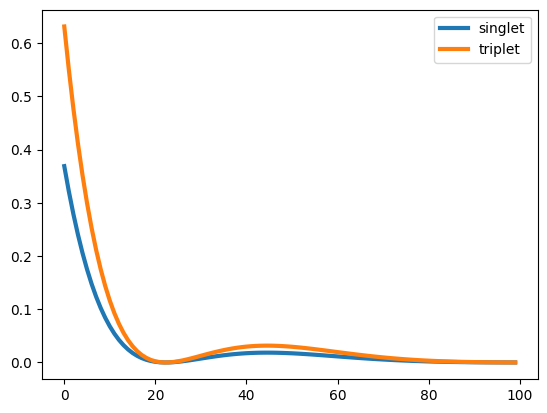

In [79]:
plt.plot(np.sum(fs, axis=0)/np.sum(fs+ft, axis=0)[0], lw=3, label='singlet')
plt.plot(np.sum(ft, axis=0)/np.sum(fs+ft, axis=0)[0], lw=3, label='triplet')

plt.legend();

#### **Triplet Components**

/tmp/ipykernel_37613/706087418.py:17: RuntimeWarning: invalid value encountered in add
  norm = np.max(F0+Fp1+Fm1)


nan


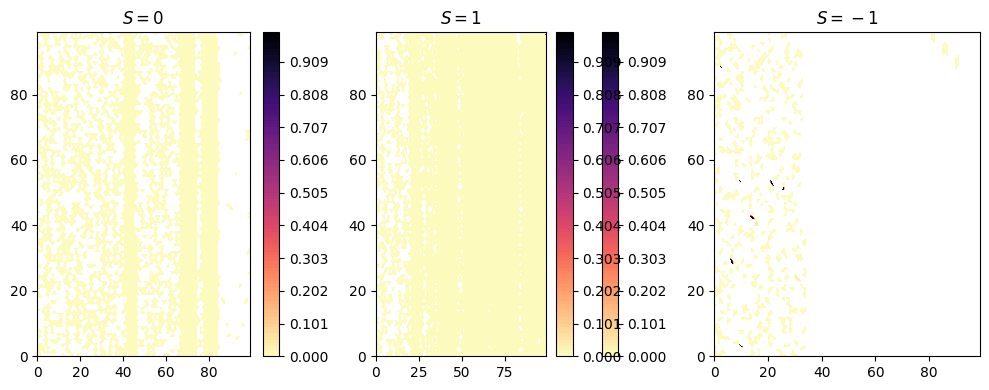

In [94]:
F0 = np.empty((k_dim, z_dim))
Fp1 = np.empty((k_dim, z_dim))
Fm1 = np.empty((k_dim, z_dim))


for F1 in F_triplet:
    for f in F1:

        f0, fp1, fm1 = Get_Spin_Projections(f)

        F0[idx][jdx] = np.linalg.norm(f0)
        Fp1[idx][jdx] = np.linalg.norm(fp1)
        Fm1[idx][jdx] = np.linalg.norm(fm1)



norm = np.max(F0+Fp1+Fm1)
print(norm)


fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(F0.T, levels=np.linspace(0,1, 100),  cmap='magma_r')#, vmin=0, vmax=1)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('$S=0$')

# Second contour plot
c2 = axes[1].contourf(Fp1.T, levels=np.linspace(0,1, 100), cmap='magma_r')#, vmin=0, vmax=1)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('$S=1$')

# Third contour plot
c3 = axes[2].contourf(Fm1.T, levels=np.linspace(0,1, 100), cmap='magma_r')#, vmin=0, vmax=1)
fig.colorbar(c3, ax=axes[1])
axes[2].set_title('$S=-1$')


plt.tight_layout()
plt.show()

### **Momentum Symmetry**

In [7]:
k_dim, z_dim = F_data.shape

# matrices for signlet
F_even = np.zeros((z_dim,4,4), dtype='complex')
# matrices for odd components
F_odd = np.zeros((z_dim,4,4), dtype='complex')

# loop over space
for iz in range(z_dim):

    # loop over matrices in momentum 
    for ik in range(k_dim):

        # spin normal matrix
        f_k = Change_Basis(F_data[ik][iz]) 
        # spin swap matrix
        f_kinv = Change_Basis(F_data[-ik-1][iz])
        
        # sum along k odd matrices
        F_odd[iz] += 0.5*(f_k - f_kinv) 
        # sum along k even matrices
        F_even[iz] += 0.5*(f_k + f_kinv) 

print(F_even.shape, F_odd.shape)

(100, 4, 4) (100, 4, 4)


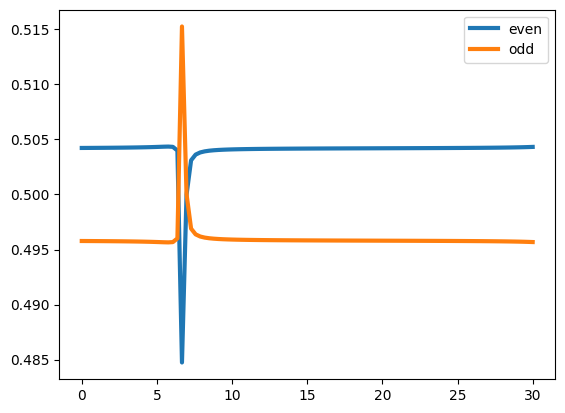

In [8]:
# norm of even
fe = np.array([np.linalg.norm(f) for f in F_singlet])
# norm of odd
fo = np.array([np.linalg.norm(f) for f in F_triplet])

plt.plot(Z, fe/(fe+fo), lw=3, label='even')
plt.plot(Z, fo/(fe+fo), lw=3, label='odd')

#plt.ylim(0,1.)
plt.legend();